In [38]:
import pandas as pd 
from pandas.api.types import CategoricalDtype
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

from prophet import Prophet
from scipy.stats import iqr

colour_pal = sns.color_palette('flare')

Custom Function for Calculating Mean Absolute Percentage Error

In [4]:
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
   
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Load DataSet (PJM East)

In [7]:
pjme = pd.read_csv('DataSet/Regions/PJME_hourly.csv', index_col=[0], parse_dates=[0])
pjme.head(10)


,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0
2002-12-31 06:00:00,26222.0
2002-12-31 07:00:00,28702.0
2002-12-31 08:00:00,30698.0
2002-12-31 09:00:00,31800.0


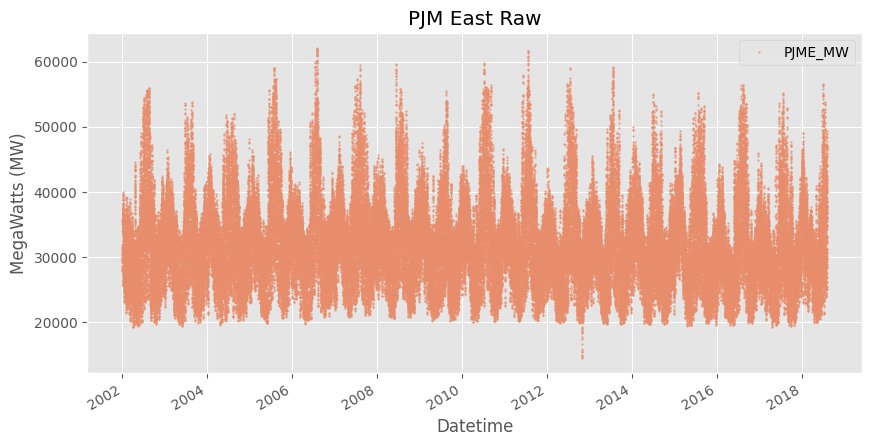

In [16]:
pjme.plot(style='.', figsize=(10,5),ms=1, color=colour_pal,ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.show()

### Outlier Analysis and Removal 

In [17]:
pjme.describe()

,PJME_MW
count,145366.000000
mean,32080.222831
std,6464.012166
min,14544.000000
25%,27573.000000
50%,31421.000000
75%,35650.000000
max,62009.000000


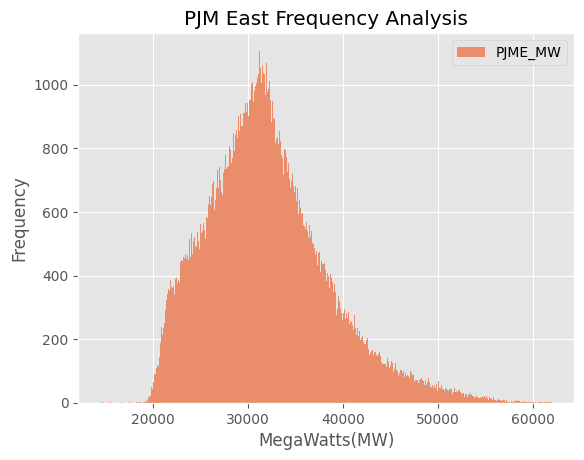

In [21]:
pjme.plot(kind='hist', bins=500, color=colour_pal,xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

In [28]:
iqr_value = iqr(pjme['PJME_MW'])
lower_threshold = np.quantile(pjme['PJME_MW'], 0.25) - ((1.5) * (iqr_value))
upper_threshold = np.quantile(pjme['PJME_MW'], 0.75) + ((1.5) * (iqr_value))

print('Outlier threshold calculations:',f'IQR: {iqr_value}', f'Lower threshold:{lower_threshold}', f'Upper threshold: {upper_threshold}')

Outlier threshold calculations: IQR: 8077.0 Lower threshold:15457.5 Upper threshold: 47765.5


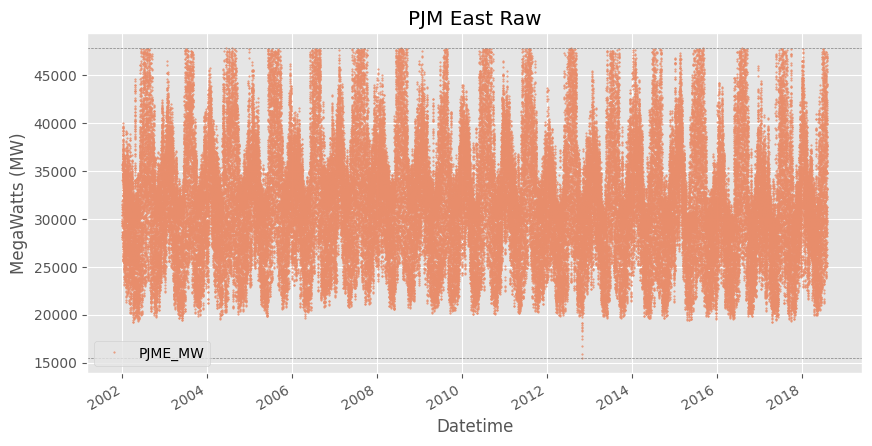

In [35]:
pjme.plot(style='.', figsize=(10, 5), ms=1, color=colour_pal,
          ylabel='MegaWatts (MW)', title='PJM East Raw')
plt.axhline(y=upper_threshold, color='grey', linestyle='--',linewidth=0.5)
plt.axhline(y=lower_threshold, color='grey', linestyle='--', linewidth=0.5)
plt.show()

In [36]:
pjme = pjme.query('PJME_MW <= @upper_threshold and PJME_MW >= @lower_threshold').copy()

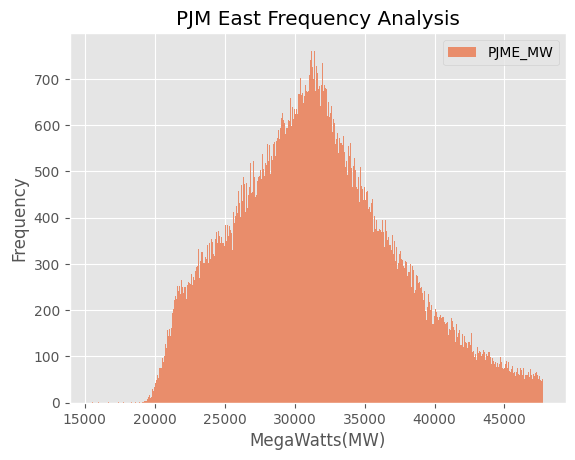

In [37]:
pjme.plot(kind='hist', bins=500, color=colour_pal, xlabel='MegaWatts(MW)', title='PJM East Frequency Analysis')
plt.show()

### Feature Creation

In [39]:
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)

In [45]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                          )
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
           'dayofyear', 'dayofmonth', 'weekday',
            'season']]
    if label:
        y = df[label]
        return X, y
    return X

In [46]:
X, y = create_features(pjme, label='PJME_MW')
features_and_target = pd.concat([X, y], axis=1)

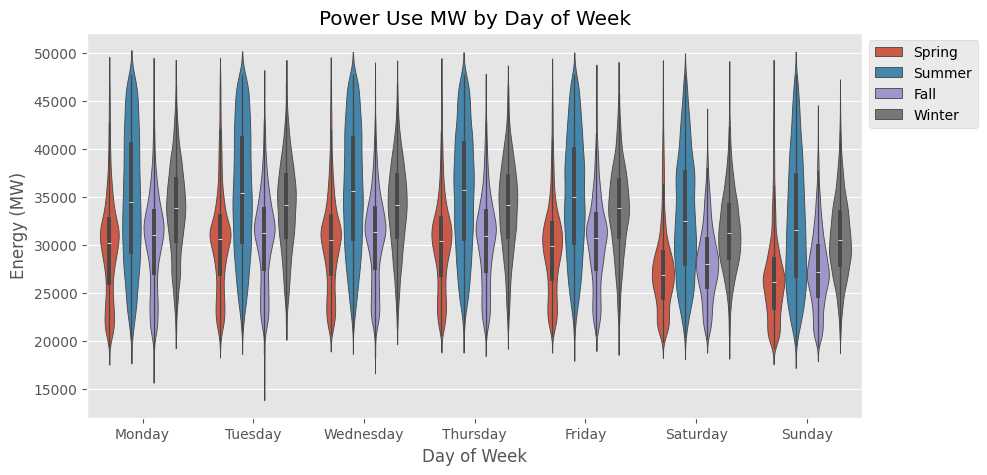

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

#### Correlation Analysis
- environmental factors
- holidays
- employment vs unemployment
- density of people / number of people in a house hold
- types of energy productions
- use heat maps and scatter plots to determine the correlatins and if relevant

### Train/Test Split
- will split train and test on Jan 01  (80:20 split)


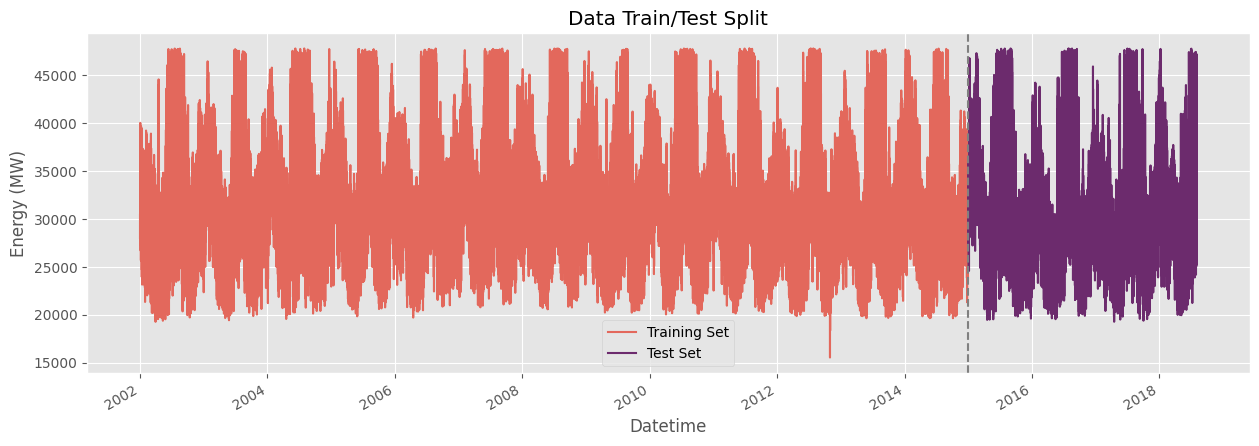

In [54]:
pjme_train = pjme.loc[pjme.index < '01-01-2015']
pjme_test = pjme.loc[pjme.index > '01-01-2015']

fig, ax =plt.subplots(figsize=(15,5))
pjme_train.plot(ax=ax, label='Training Set', color=colour_pal[1], title='Data Train/Test Split')
pjme_test.plot(ax=ax, label='Test Set', color=colour_pal[5])
ax.axvline('01-01-2015', color='grey', ls='--')
ax.legend(['Training Set', 'Test Set'])
ax.set_ylabel('Energy (MW)')
plt.show()

### Initial Prophet Model

In [65]:
pjme_train_prophet = pjme_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [66]:
%%time
model = Prophet()
model.fit(pjme_train_prophet)

16:38:02 - cmdstanpy - INFO - Chain [1] start processing
16:38:30 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 3.1 s, sys: 94.6 ms, total: 3.2 s
Wall time: 31.2 s


In [80]:
pjme_test_prophet = pjme_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

pjme_test_fcst = model.predict(pjme_test_prophet)
pjme_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31135.272119,25013.605044,32976.138161,31135.272119,31135.272119,-2353.405363,-2353.405363,-2353.405363,-4138.878349,...,1182.423823,1182.423823,1182.423823,603.049163,603.049163,603.049163,0.0,0.0,0.0,28781.866756
1,2015-01-01 02:00:00,31135.246857,23599.036522,31171.277884,31135.246857,31135.246857,-3840.515595,-3840.515595,-3840.515595,-5620.179563,...,1175.245382,1175.245382,1175.245382,604.418587,604.418587,604.418587,0.0,0.0,0.0,27294.731263
2,2015-01-01 03:00:00,31135.221596,22511.927388,30483.267025,31135.221596,31135.221596,-4715.031940,-4715.031940,-4715.031940,-6487.701420,...,1166.839870,1166.839870,1166.839870,605.829609,605.829609,605.829609,0.0,0.0,0.0,26420.189656
3,2015-01-01 04:00:00,31135.196334,22145.629685,30380.120651,31135.196334,31135.196334,-4870.325706,-4870.325706,-4870.325706,-6634.931795,...,1157.323834,1157.323834,1157.323834,607.282255,607.282255,607.282255,0.0,0.0,0.0,26264.870628
4,2015-01-01 05:00:00,31135.171073,23080.708898,30629.697667,31135.171073,31135.171073,-4204.601565,-4204.601565,-4204.601565,-5960.204563,...,1146.826450,1146.826450,1146.826450,608.776549,608.776549,608.776549,0.0,0.0,0.0,26930.569508


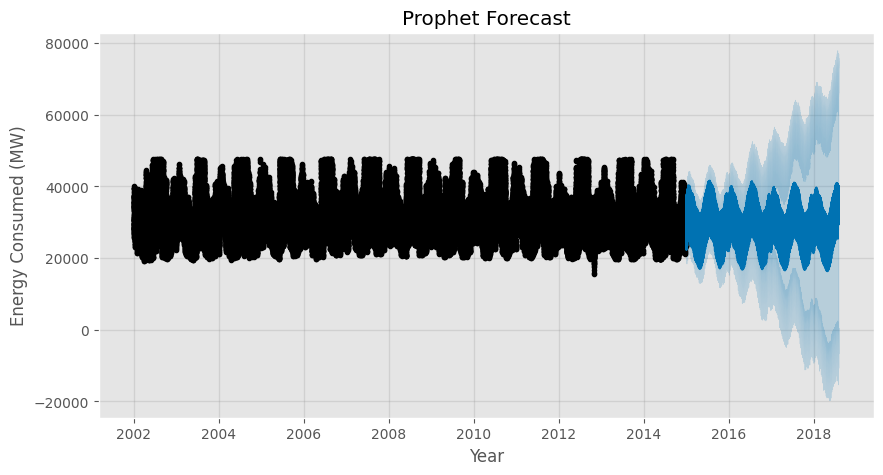

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

### Visual Comparison of Forecast to Test

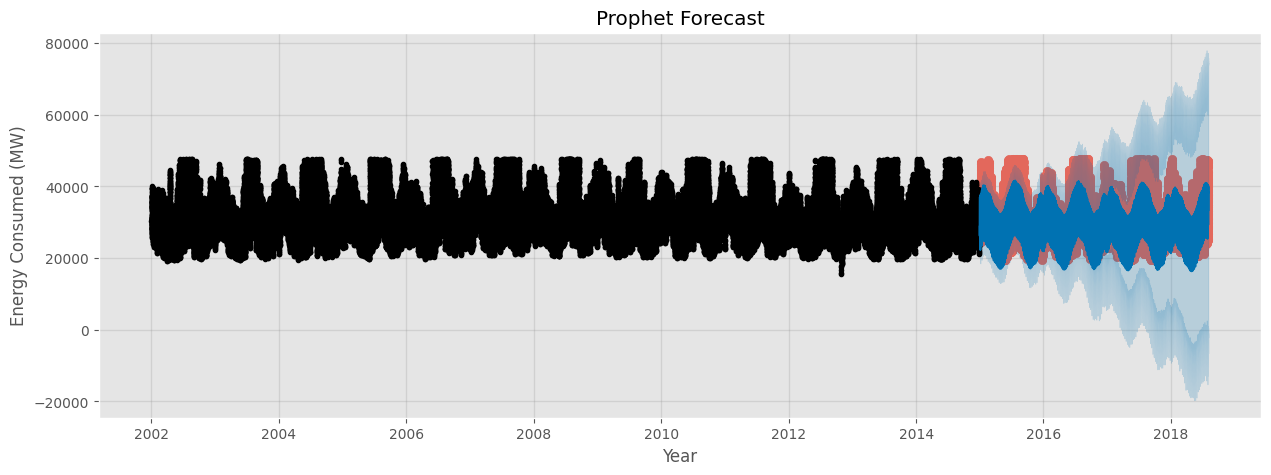

In [90]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set(title='Prophet Forecast', xlabel='Year', ylabel='Energy Consumed (MW)')
plt.show()

#### For One Month

ConversionError: Failed to convert value(s) to axis units: '01-01-2015'

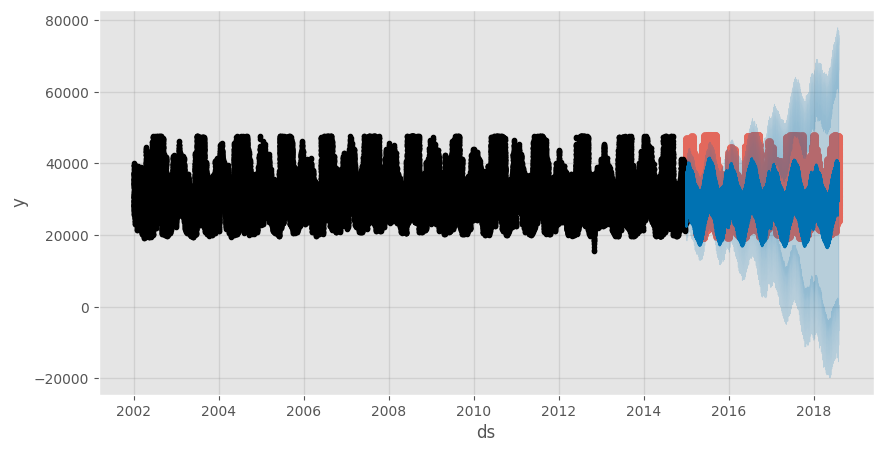

In [102]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color=colour_pal[1])
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-02-2015')
ax.set_ylim(0, 60000)
plt.suptitle('January 2015 Forecast vs Actuals')

#### For One Week

AttributeError: 'Axes' object has no attribute 'xbound'

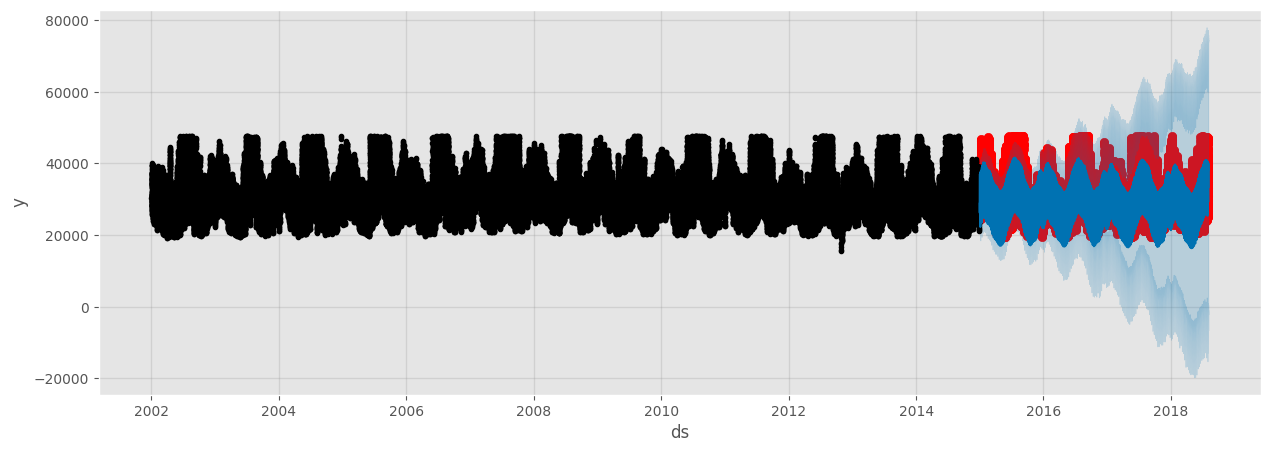

In [106]:
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(pjme_test.index, pjme_test['PJME_MW'], color='r')
fig = model.plot(pjme_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015', upper='01-08-2015')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()

### Evaluate Simple Model (Error Metrics)

In [97]:
print('RMSE:', np.sqrt(mean_squared_error(y_true=pjme_test['PJME_MW'],
                           y_pred=pjme_test_fcst['yhat'])))

MSE: 7087.379184453595


In [98]:
print('MSE:',mean_absolute_error(y_true=pjme_test['PJME_MW'],
                    y_pred=pjme_test_fcst['yhat']))

MSE: 5584.745558298455


In [99]:
print('MAPE:',mean_absolute_percentage_error(y_true=pjme_test['PJME_MW'],
                               y_pred=pjme_test_fcst['yhat']))

MAPE: 18.39489647999724


# Time Series Cross Validation
- another method of spliting data sets for predicting into the future

In [61]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
pjme = pjme.sort_index()

CPU times: user 2.14 s, sys: 13.9 ms, total: 2.16 s
Wall time: 780 ms


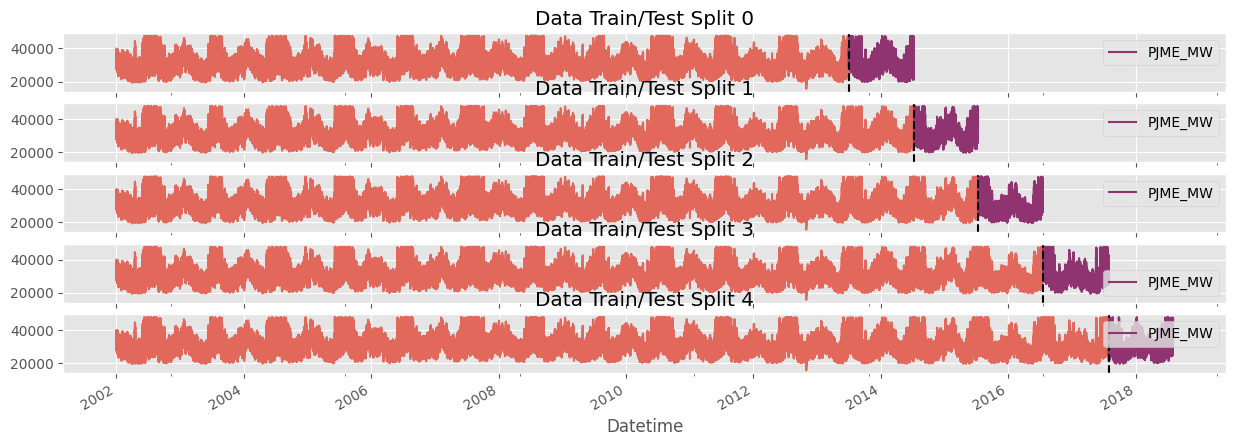

In [62]:
%%time

fig, ax = plt.subplots(5, 1, figsize=(15,5), sharex=True)
fold=0

for train_index, val_index in tss.split(pjme):
    train = pjme.iloc[train_index]
    test = pjme.iloc[val_index]
    train['PJME_MW'].plot(ax=ax[fold], label='Training Set', color=colour_pal[1], title=f'Data Train/Test Split {fold}')
    test.plot(ax=ax[fold], label='Test Set', color=colour_pal[4])
    ax[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1


### Lag Features
- What was the target (x) days in the past

In [20]:
def add_lags(df):
    target_map = df['PJME_MW'].to_dict()
    df['lag_1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag_2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag_3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)    

    return df

In [21]:
df = add_lags(df)
df.tail()

,PJME_MW,lag_1,lag_2,lag_3
Datetime,,,,
2018-08-02 20:00:00,44057.0,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,33539.0,32094.0,31695.0


### Feature Importance

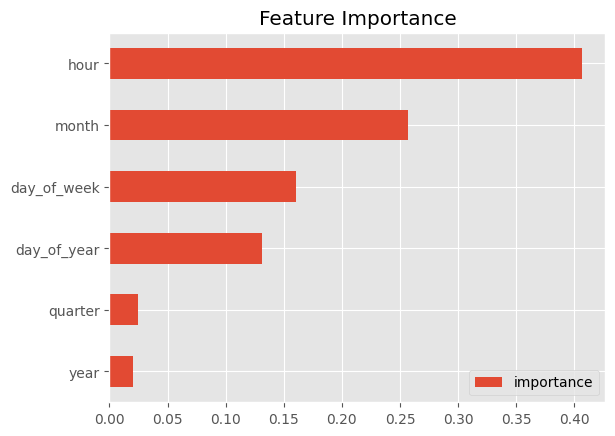

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 3828.93


### Predicting the Future
- estimate up to 500 in this case due to the fact that beyond this the model begins to overfit

### Saving Model for Later

In [ ]:
reg.save_model('model.json')

In [ ]:
#reg_new = xgb.XGBRegressor()
#reg_new.load_model('model.json')